# Time Series Analysis - Aluminium Price

In [73]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
os.chdir(r'C:\Users\HP\Desktop')
data = pd.read_excel('Aluminium_Price.xlsx',sheet_name='Investing.com',index_col=[0])
data.index = pd.to_datetime(data.index)

In [74]:
data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2024-06-07,241.85,241.60,242.15,241.60,0.02K,0.0010
2024-06-06,241.60,240.00,242.65,239.80,1.58K,0.0111
2024-06-05,238.95,239.80,240.35,237.55,2.06K,-0.0087
2024-06-04,241.05,241.70,243.15,238.85,1.92K,0.0019
2024-06-03,240.60,238.65,242.50,237.85,2.04K,-0.0243


In [75]:
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
            Price        Open        High         Low        Chg%
count  885.000000  885.000000  885.000000  885.000000  884.000000
mean   211.589209  211.704407  213.478249  209.818079    0.000548
std     24.010883   24.177594   24.912261   23.394854    0.013227
min    161.050000  160.700000  161.400000  159.200000   -0.069900
25%    199.600000  199.600000  200.900000  198.200000   -0.006500
50%    206.650000  206.800000  208.200000  205.250000    0.000200
75%    220.550000  220.600000  222.450000  218.200000    0.008200
max    308.350000  314.000000  325.400000  304.700000    0.057600


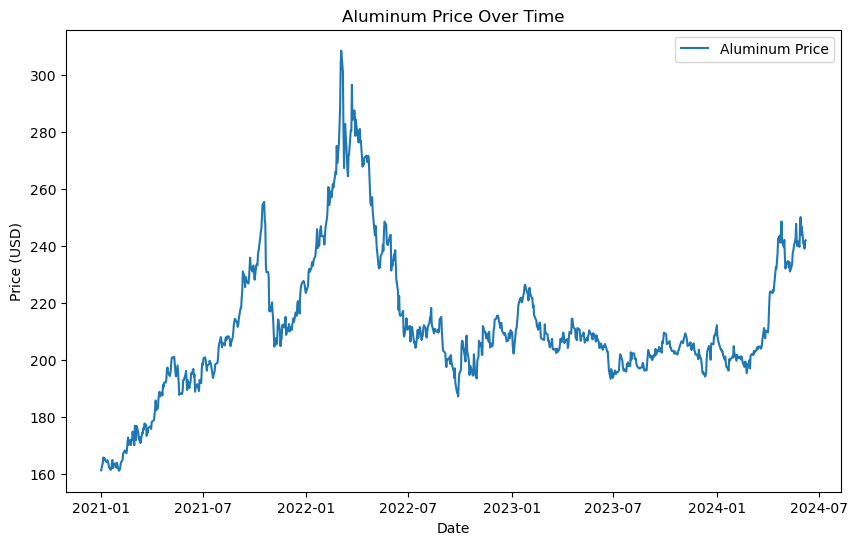

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Price'], label='Aluminum Price')
plt.title('Aluminum Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

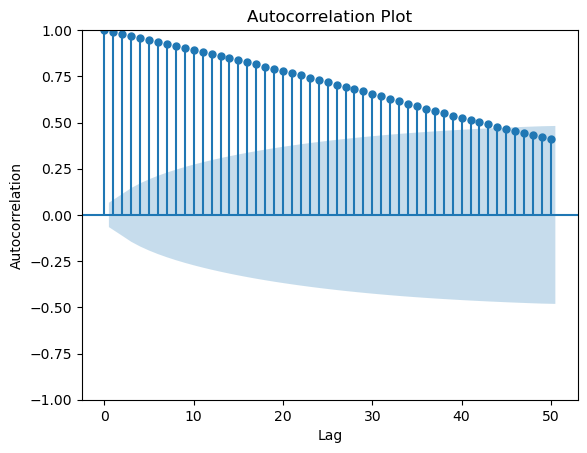

In [77]:
sm.graphics.tsa.plot_acf(data['Price'], lags=50)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

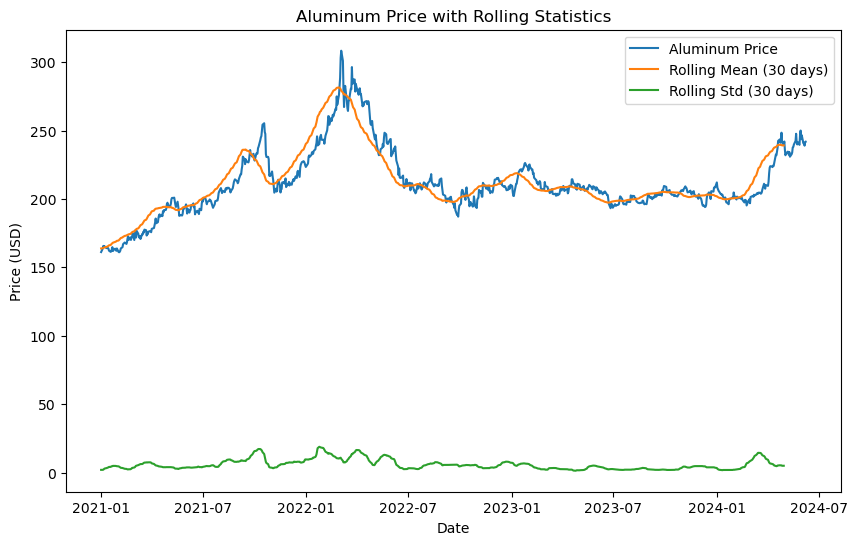

In [78]:
rolling_mean = data['Price'].rolling(window=30).mean()
rolling_std = data['Price'].rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Price'], label='Aluminum Price')
plt.plot(rolling_mean, label='Rolling Mean (30 days)')
plt.plot(rolling_std, label='Rolling Std (30 days)')
plt.title('Aluminum Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [80]:
data = data['Price'].values.reshape(-1, 1)

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [82]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

3/3 [==============================] - 0s 28ms/step


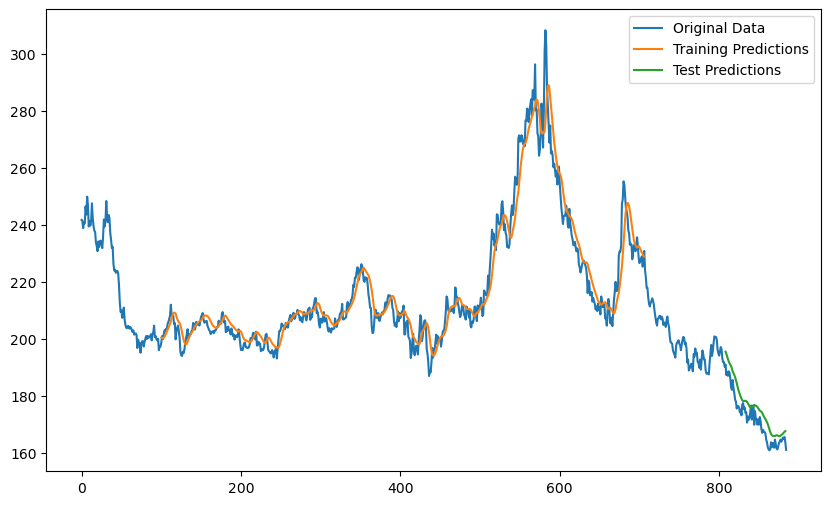

In [83]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(time_step, len(train_predict) + time_step), train_predict, label='Training Predictions')
plt.plot(np.arange(len(train_predict) + (time_step * 2) + 1, len(scaled_data) - 1), test_predict, label='Test Predictions')
plt.legend()
plt.show()


In [84]:
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [90]:
train_mae = mean_absolute_error(y_train_inv, train_predict)
test_mae = mean_absolute_error(y_test_inv, test_predict)

train_mse = mean_squared_error(y_train_inv, train_predict)
test_mse = mean_squared_error(y_test_inv, test_predict)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_r2 = r2_score(y_train_inv, train_predict)
test_r2 = r2_score(y_test_inv, test_predict)

In [86]:
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

Training MAE: 3.9999876471681293
Test MAE: 4.449299621582031
Training MSE: 31.719287120273854
Test MSE: 24.439313051458925
Training RMSE: 5.6319878480225665
Test RMSE: 4.943613359826891
Training R^2: 0.9362981345276945
Test R^2: 0.617090870947985


In [87]:
train_abs_error = np.abs(train_predict - y_train_inv)
train_rel_error = train_abs_error / y_train_inv
train_error_percentage = np.mean(train_rel_error)
print(f"Training Error Percentage: {train_error_percentage:.2f}%")

Training Error Percentage: 0.02%


In [89]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
test_abs_error = np.abs(test_predict - y_test_inv)
test_rel_error = test_abs_error / y_test_inv
test_error_percentage = np.mean(test_rel_error) * 100
print(f"Test Error Percentage: {test_error_percentage:.2f}%")

Test Error Percentage: 2.59%
